# Bomberle: Game Mechanics Explained

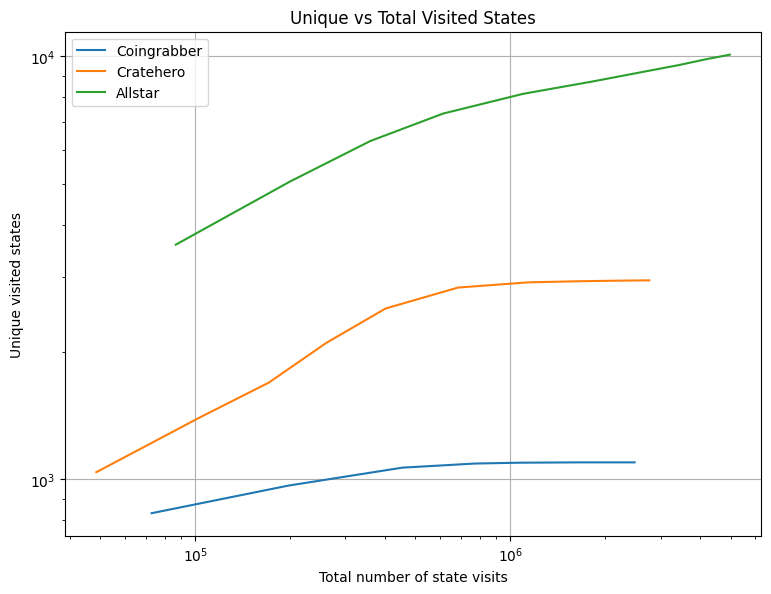

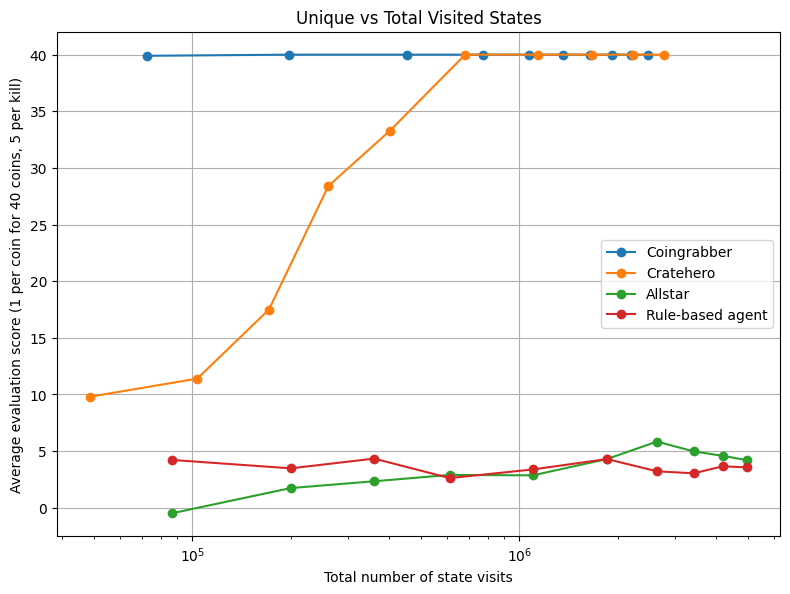

In [21]:
#!/usr/bin/env python3
import os
import re
import json
import numpy as np
import matplotlib.pyplot as plt

def _npz_item(data, key, default=None):
    """Safely unwrap a 0-D object array from an npz (saved via np.array(obj, dtype=object))."""
    if key in data.files:
        return data[key].item()
    return default

def _collect_npz_files_with_chunk_indices(folder):
    """
    Return dict: chunk_idx -> path for all .npz files in folder.
    Prefer parsing from filename '*_chunk_####.npz'; fallback to reading meta.chunk_idx.
    """
    npz_files = {}
    name_pat = re.compile(r".*_chunk_(\d+)\.npz$")
    for f in os.listdir(folder):
        if not f.endswith(".npz"):
            continue
        path = os.path.join(folder, f)
        m = name_pat.match(f)
        if m:
            npz_files[int(m.group(1))] = path
            continue
        # Fallback: open and read meta.chunk_idx
        try:
            with np.load(path, allow_pickle=True) as data:
                meta = _npz_item(data, "meta", {}) or {}
                ci = meta.get("chunk_idx", None)
                if ci is not None:
                    npz_files[int(ci)] = path
        except Exception:
            # Ignore unreadable files
            pass
    return npz_files

def load_q_visits_snapshots(folder, agent=None):
    """Load q_visits from NPZ snapshots and matching evaluation JSON results."""
    # Find NPZ snapshots and eval JSONs
    npz_files = _collect_npz_files_with_chunk_indices(folder)
    eval_pat = re.compile(r"eval_chunk_(\d+)\.json$")
    eval_files = {}
    for f in os.listdir(folder):
        m = eval_pat.match(f)
        if m:
            eval_files[int(m.group(1))] = os.path.join(folder, f)

    # Only keep chunks where we have both NPZ and eval
    chunk_indices = sorted(set(npz_files.keys()) & set(eval_files.keys()))

    total_counts = []
    unique_counts = []
    avg_scores = []

    for idx in chunk_indices:
        # --- Load NPZ snapshot ---
        with np.load(npz_files[idx], allow_pickle=True) as data:
            q_visits = _npz_item(data, "q_visits", {})
            q_visits = _npz_item(data, "q_visits", {})
            q_visits = _npz_item(data, "q_visits", {})
            q_visits = _npz_item(data, "q_visits", {})

        # Aggregate visit metrics
        total_visits = sum(np.sum(v) for v in q_visits.values())
        unique_states = len(q_visits)

        # --- Load Evaluation JSON ---
        with open(eval_files[idx], "r") as f:
            eval_data = json.load(f)

        agent_data = None
        by_agent = eval_data.get("by_agent", {})

        if agent is None:
            # Pick the first agent name containing 'tq'
            for agent_name, stats in by_agent.items():
                if "tq" in agent_name:
                    agent_data = stats
                    break
            if agent_data is None and by_agent:
                # Fallback to any agent if none has 'tq'
                first_key = next(iter(by_agent))
                agent_data = by_agent[first_key]
        else:
            if agent not in by_agent:
                raise KeyError(f"Agent '{agent}' not found in eval for chunk {idx}. "
                               f"Available: {list(by_agent.keys())}")
            agent_data = by_agent[agent]

        # Score heuristic: prefer 'score', else coins + 5*kills
        score_total = None# agent_data.get("score", None)
        if score_total is None:
            score_total = agent_data.get("coins", 0) + 5 * agent_data.get("kills", 0) - 5 * agent_data.get("suicides", 0)

        rounds = max(1, int(agent_data.get("rounds", 1)))
        avg_score = score_total / rounds

        # Append metrics
        total_counts.append(total_visits)
        unique_counts.append(unique_states)
        avg_scores.append(avg_score)

    return chunk_indices, total_counts, unique_counts, avg_scores


# --- Example usage (point these to the folders containing your .npz + eval JSONs) ---
dict1_folder = "agent_code/tq_coingrabber/dicts"
dict2_folder = "agent_code/tq_cratehero/dicts"
dict3_folder = "agent_code/tq_allstar/dicts"

c1, t1, u1, a1 = load_q_visits_snapshots(dict1_folder)
c2, t2, u2, a2 = load_q_visits_snapshots(dict2_folder)
c3, t3, u3, a3 = load_q_visits_snapshots(dict3_folder, agent="tq_allstar")
c4, t4, u4, a4 = load_q_visits_snapshots(dict3_folder, agent="rule_based_agent_0")

# --- Plots (unchanged) ---
plt.figure(figsize=(8,6))
plt.plot(t1, u1, label="Coingrabber")
plt.plot(t2, u2, label="Cratehero")
plt.plot(t3, u3, label="Allstar")
plt.xlabel("Total number of state visits")
plt.ylabel("Unique visited states")
plt.title("Unique vs Total Visited States")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xscale("log")
plt.yscale("log")
plt.show()

plt.figure(figsize=(8,6))
plt.plot(t1, a1, label="Coingrabber", marker="o")
plt.plot(t2, a2, label="Cratehero", marker="o")
plt.plot(t3, a3, label="Allstar", marker="o")
plt.plot(t4, a4, label="Rule-based agent", marker="o")
plt.xlabel("Total number of state visits")
plt.ylabel("Average evaluation score (1 per coin for 40 coins, 5 per kill)")
plt.title("Unique vs Total Visited States")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xscale("log")
plt.show()


In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_dict_histograms(folder):
    files = sorted([f for f in os.listdir(folder) if f.endswith(".npz")])
    for f in files:
        path = os.path.join(folder, f)
        with np.load(path, allow_pickle=True) as data:
            q            = data["q"].item()
            q_visits     = data["q_visits"].item()
            q_td_error   = data["q_td_error"].item()
            q_update_mag = data["q_update_mag"].item()

        def flatten(d):
            return np.concatenate([np.ravel(v) for v in d.values()]) if d else np.array([])

        q_vals   = flatten(q)
        qv_vals  = flatten(q_visits)
        tde_vals = flatten(q_td_error)
        upm_vals = flatten(q_update_mag)

        fig, axs = plt.subplots(2, 2, figsize=(10,8))
        fig.suptitle(f"Snapshot: {f}")

        axs[0,0].hist(q_vals, bins=50)
        axs[0,0].set_title("Q values")

        axs[0,1].hist(qv_vals, bins=50, log=True)
        axs[0,1].set_title("Q visits (log scale)")

        axs[1,0].hist(tde_vals, bins=50)
        axs[1,0].set_title("TD error δ")

        axs[1,1].hist(upm_vals, bins=50, log=True)
        axs[1,1].set_title("|ΔQ| = |α·δ| (log scale)")

        plt.tight_layout()
        plt.show()

# Example usage:
# plot_dict_histograms("agent_code/tq_coingrabber/dicts")


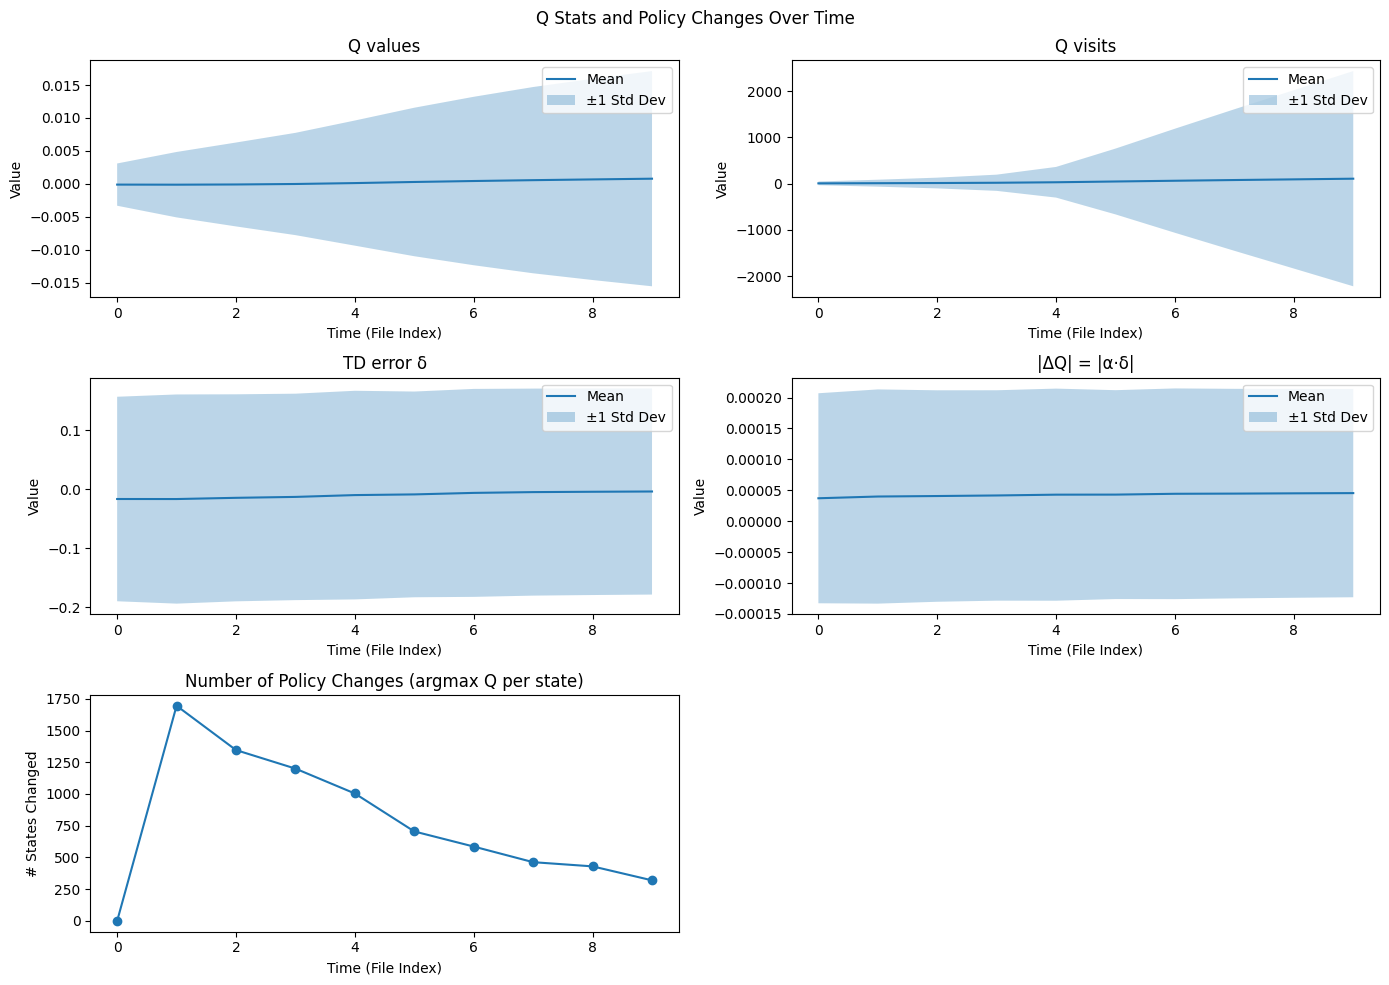

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_q_stats_and_policy_changes(folder):
    files = sorted([f for f in os.listdir(folder) if f.endswith(".npz")])

    timestamps = []
    stats = {
        "q": {"mean": [], "std": []},
        "q_visits": {"mean": [], "std": []},
        "q_td_error": {"mean": [], "std": []},
        "q_update_mag": {"mean": [], "std": []},
    }
    policy_changes = []  # Number of changed states between steps

    previous_q_argmax = None  # Stores previous policy

    for f in files:
        path = os.path.join(folder, f)
        with np.load(path, allow_pickle=True) as data:
            q            = data["q"].item()
            q_visits     = data["q_visits"].item()
            q_td_error   = data["q_td_error"].item()
            q_update_mag = data["q_update_mag"].item()

        timestamps.append(f)

        # Compute statistics
        def flatten(d):
            return np.concatenate([np.ravel(v) for v in d.values()]) if d else np.array([])

        for key, values in zip(
            ["q", "q_visits", "q_td_error", "q_update_mag"],
            [q, q_visits, q_td_error, q_update_mag]
        ):
            flat = flatten(values)
            if len(flat) > 0:
                stats[key]["mean"].append(np.mean(flat))
                stats[key]["std"].append(np.std(flat))
            else:
                stats[key]["mean"].append(np.nan)
                stats[key]["std"].append(np.nan)

        # Compute policy (argmax Q-values)
        current_q_argmax = {}
        for state, q_values in q.items():
            if len(q_values) > 0:
                current_q_argmax[state] = np.argmax(q_values)

        # Count how many states changed policy
        if previous_q_argmax is None:
            policy_changes.append(0)
        else:
            change_count = 0
            all_states = set(current_q_argmax.keys()).union(previous_q_argmax.keys())
            for state in all_states:
                prev = previous_q_argmax.get(state, -1)
                curr = current_q_argmax.get(state, -1)
                if prev != curr:
                    change_count += 1
            policy_changes.append(change_count)

        previous_q_argmax = current_q_argmax

    # Plotting stats
    fig, axs = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle("Q Stats and Policy Changes Over Time")

    keys = ["q", "q_visits", "q_td_error", "q_update_mag"]
    titles = ["Q values", "Q visits", "TD error δ", "|ΔQ| = |α·δ|"]

    for ax, key, title in zip(axs.flat[:4], keys, titles):
        means = stats[key]["mean"]
        stds = stats[key]["std"]
        x = range(len(timestamps))

        ax.plot(x, means, label='Mean')
        ax.fill_between(x, np.array(means) - np.array(stds), np.array(means) + np.array(stds),
                        alpha=0.3, label='±1 Std Dev')
        ax.set_title(title)
        ax.set_xlabel("Time (File Index)")
        ax.set_ylabel("Value")
        ax.legend()

    # Plot policy changes
    axs[2, 0].plot(range(len(policy_changes)), policy_changes, marker='o')
    axs[2, 0].set_title("Number of Policy Changes (argmax Q per state)")
    axs[2, 0].set_xlabel("Time (File Index)")
    axs[2, 0].set_ylabel("# States Changed")

    # Hide unused subplot
    axs[2, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
plot_q_stats_and_policy_changes("agent_code/tq_allstar/dicts")


In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from q_helpers import describe_state, ACTS
top_n = 3
def print_highest_td_error_states(folder):
    files = sorted([f for f in os.listdir(folder) if f.endswith(".npz")])

    timestamps = []
    stats = {
        "q": {"mean": [], "std": []},
        "q_visits": {"mean": [], "std": []},
        "q_td_error": {"mean": [], "std": []},
        "q_update_mag": {"mean": [], "std": []},
    }
    policy_changes = []  # Number of changed states between steps

    previous_q_argmax = None  # Stores previous policy

    for f in files:
        path = os.path.join(folder, f)
        with np.load(path, allow_pickle=True) as data:
            q_td_error = data["q_td_error"].item()

            # Flatten into (abs_td_error, state, action) triples
            all_errors = []
            for state, actions in q_td_error.items():
                for action, td_err in enumerate(actions):
                    all_errors.append((abs(td_err), state, action))

            if not all_errors:
                print(f"{f}: no TD errors recorded")
                continue

            # Sort by error magnitude, descending
            all_errors_sorted = sorted(all_errors, key=lambda x: x[0], reverse=True)

            # Pick top N
            top = all_errors_sorted[:top_n]

            print(f"\nFile: {f}")
            for rank, (val, state, action) in enumerate(top, start=1):
                print(f" {rank}. TD error={val:.4f}, state={state}, action={ACTS[action]}")
                print(describe_state(state))



# Example usage:
print_highest_td_error_states("agent_code/tq_allstar/dicts")



File: q_table_chunk_0001.npz
 1. TD error=1.4378, state=18608, action=RIGHT
State bits        : 000100100010110000
Nearest interest  : ENEMY (UP)
May wait          : 0
May place bomb    : 0
Neighbour Up      : ENEMY
Neighbour Right   : COIN
Neighbour Down    : DANGER
Neighbour Left    : EMPTY
 2. TD error=1.4258, state=23816, action=LEFT
State bits        : 000101110100001000
Nearest interest  : ENEMY (RIGHT)
May wait          : 0
May place bomb    : 0
Neighbour Up      : DANGER
Neighbour Right   : ENEMY
Neighbour Down    : WALL
Neighbour Left    : EMPTY
 3. TD error=1.4111, state=30596, action=DOWN
State bits        : 000111011110000100
Nearest interest  : ENEMY (LEFT)
May wait          : 0
May place bomb    : 0
Neighbour Up      : CRATE
Neighbour Right   : DANGER
Neighbour Down    : EMPTY
Neighbour Left    : ENEMY

File: q_table_chunk_0002.npz
 1. TD error=2.1535, state=147592, action=UP
State bits        : 100100000010001000
Nearest interest  : ENEMY (UP)
May wait          : 1
May 

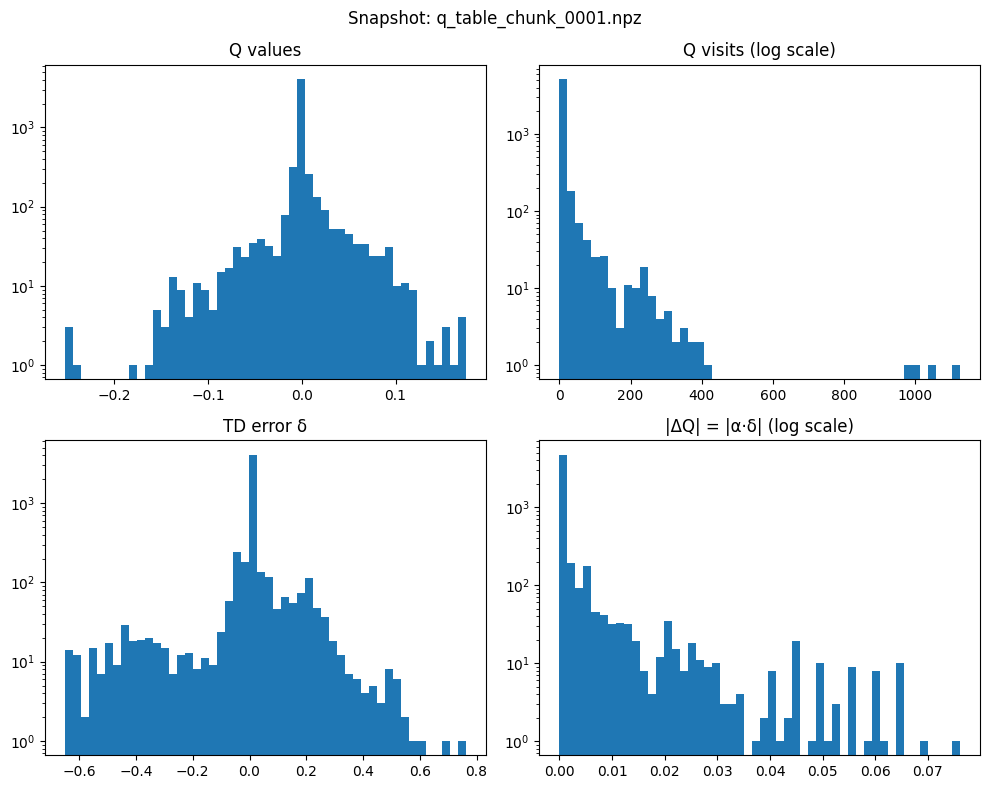

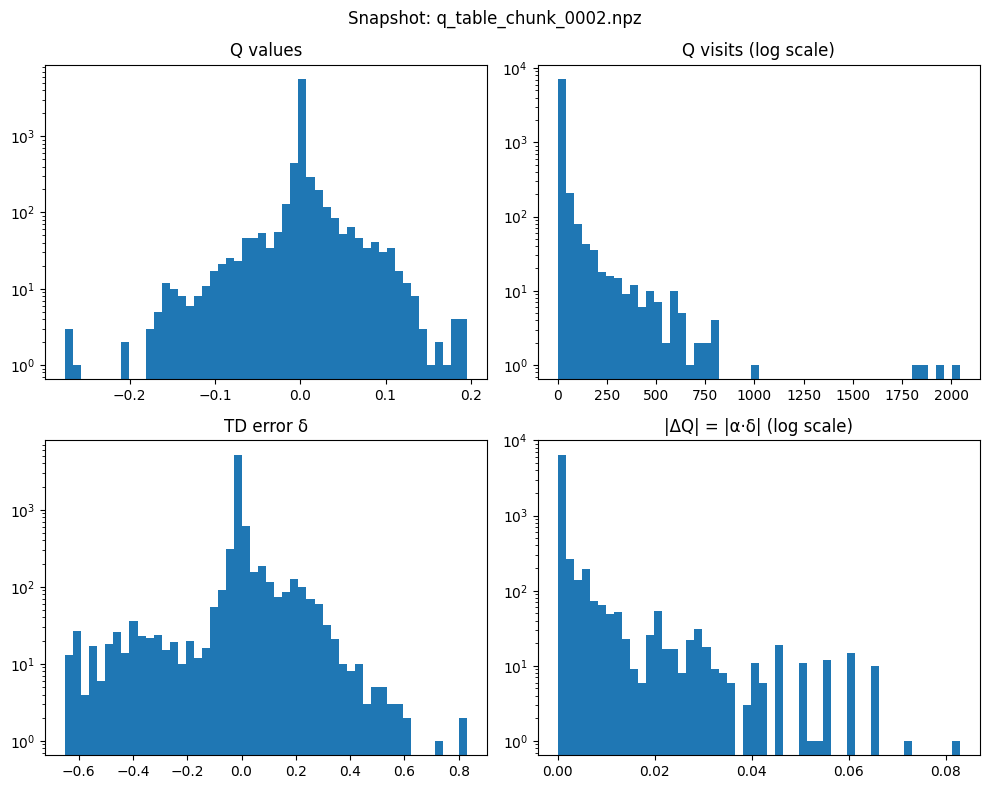

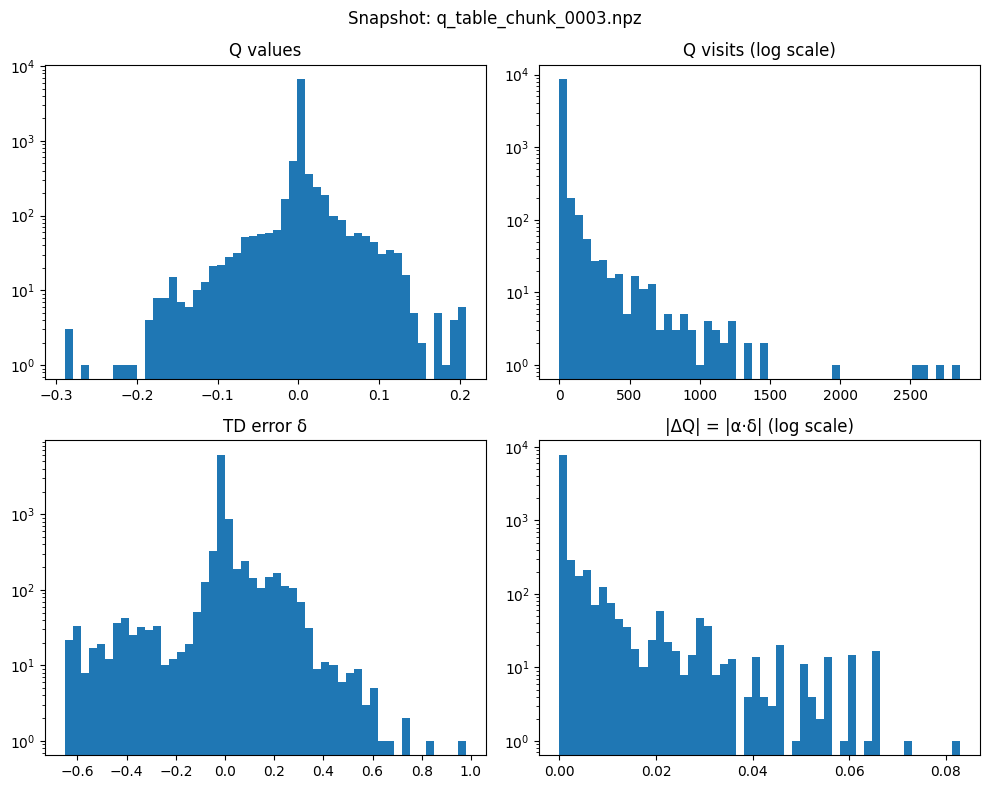

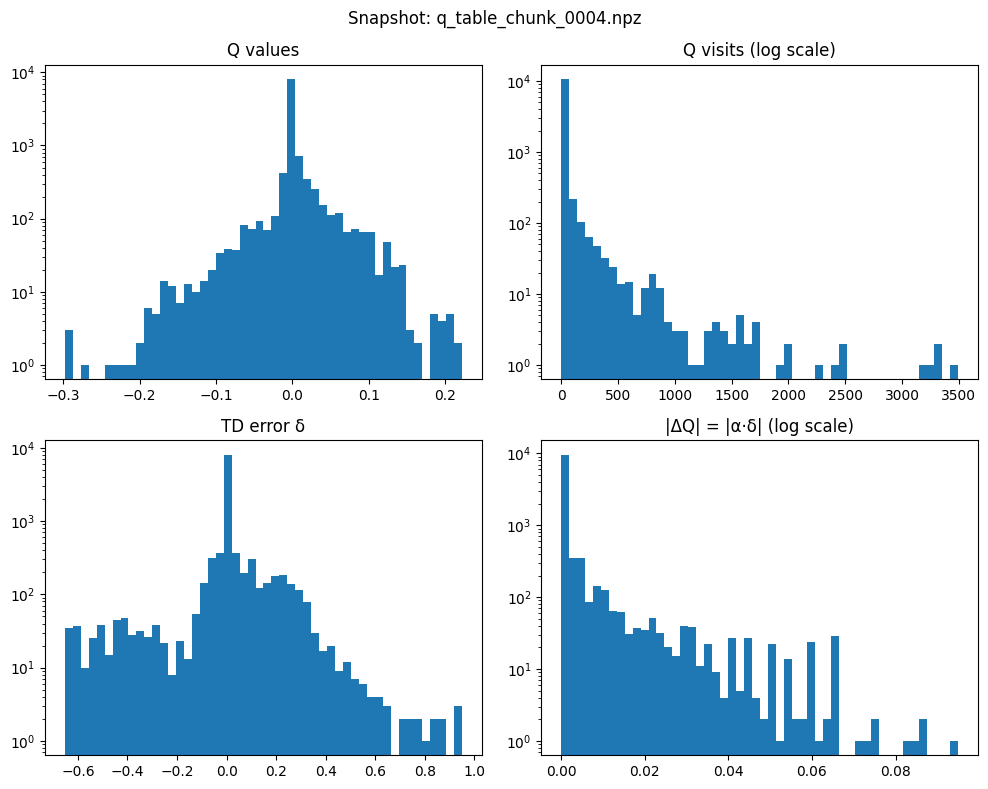

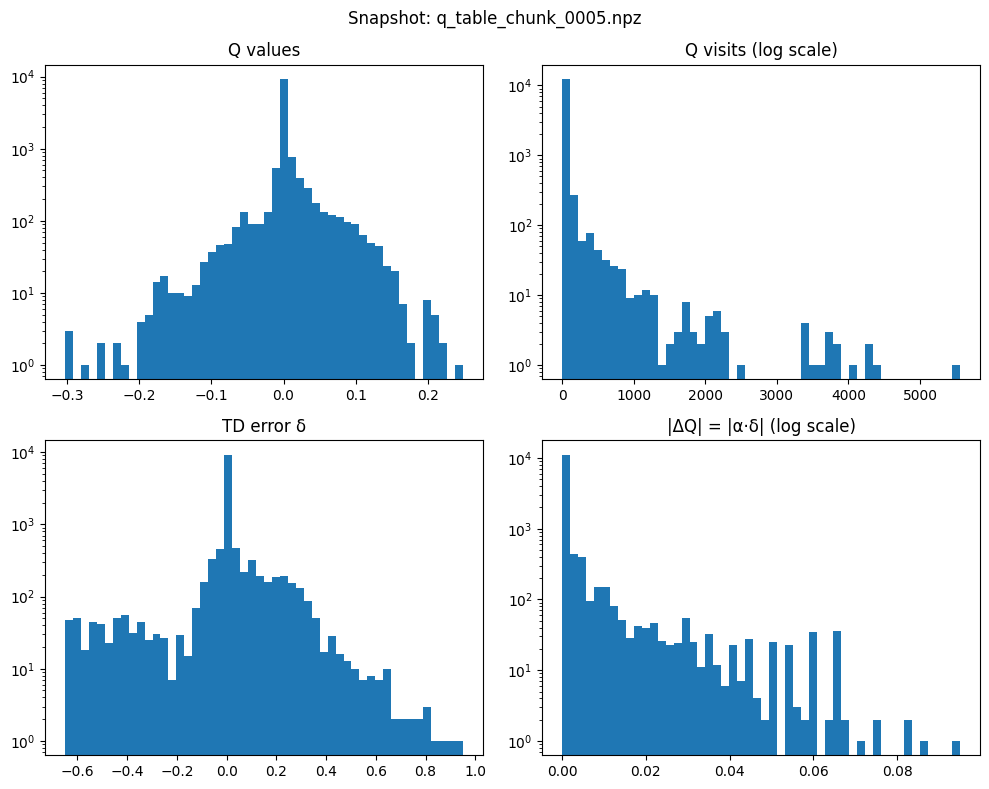

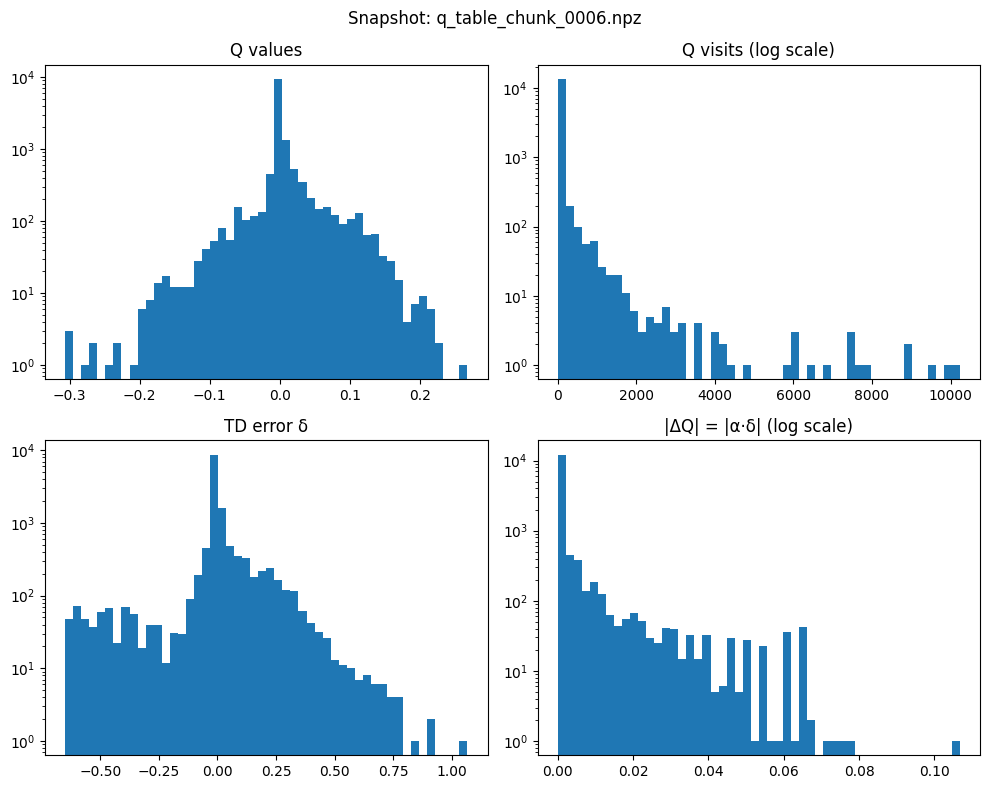

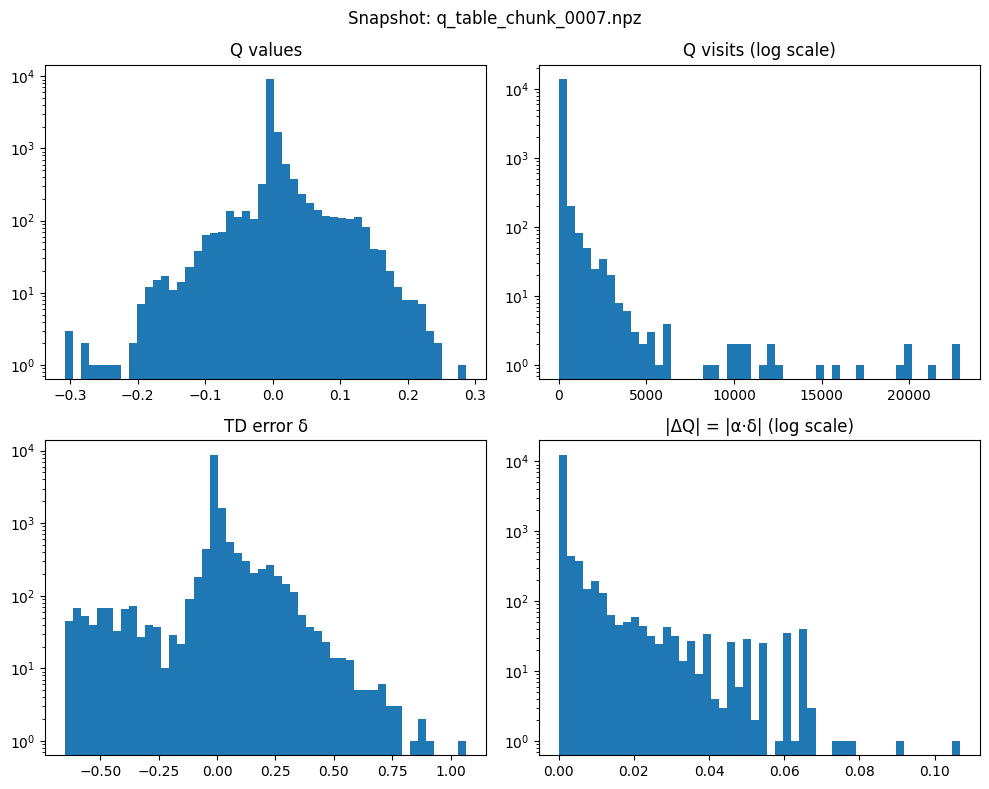

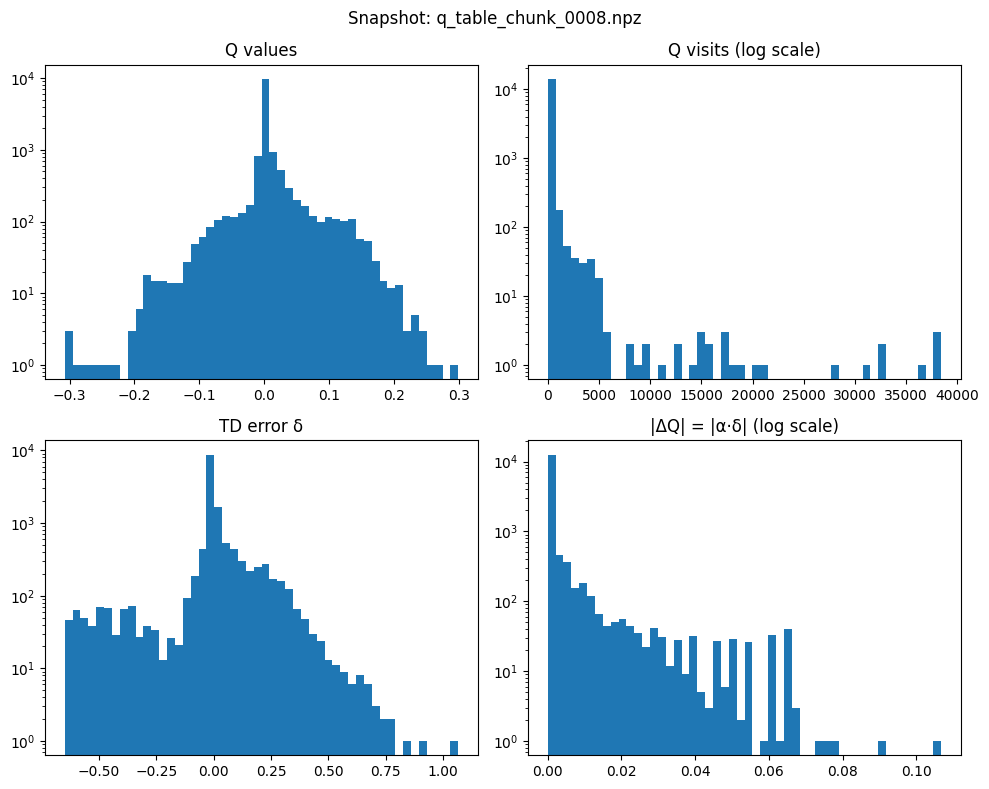

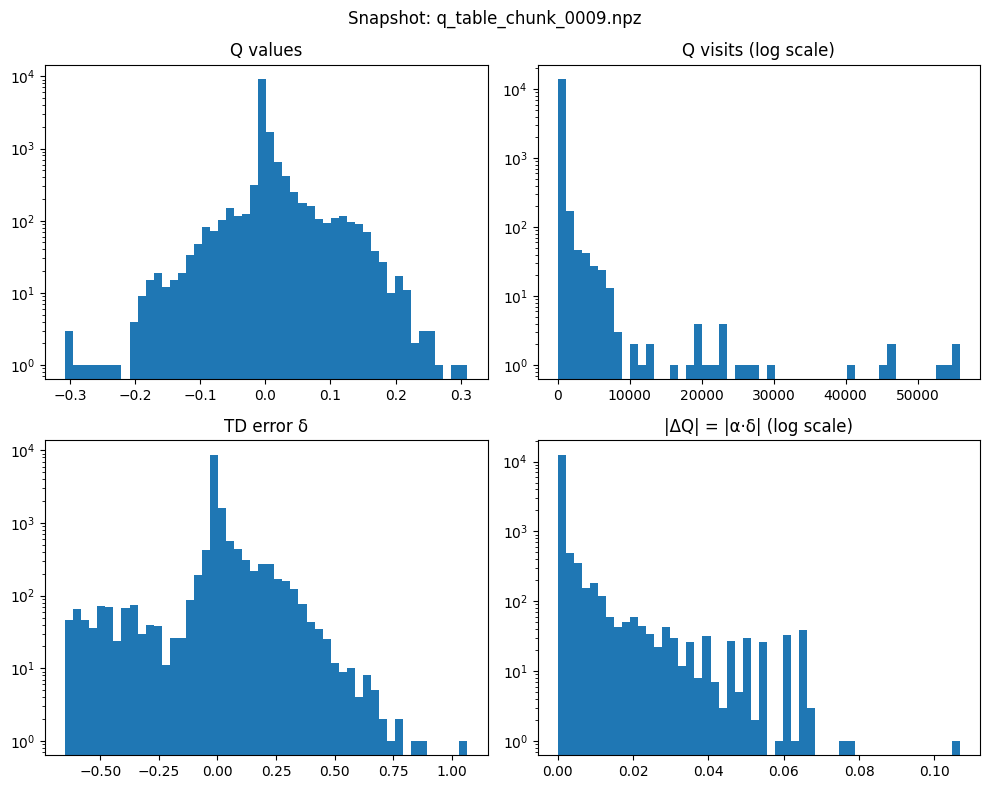

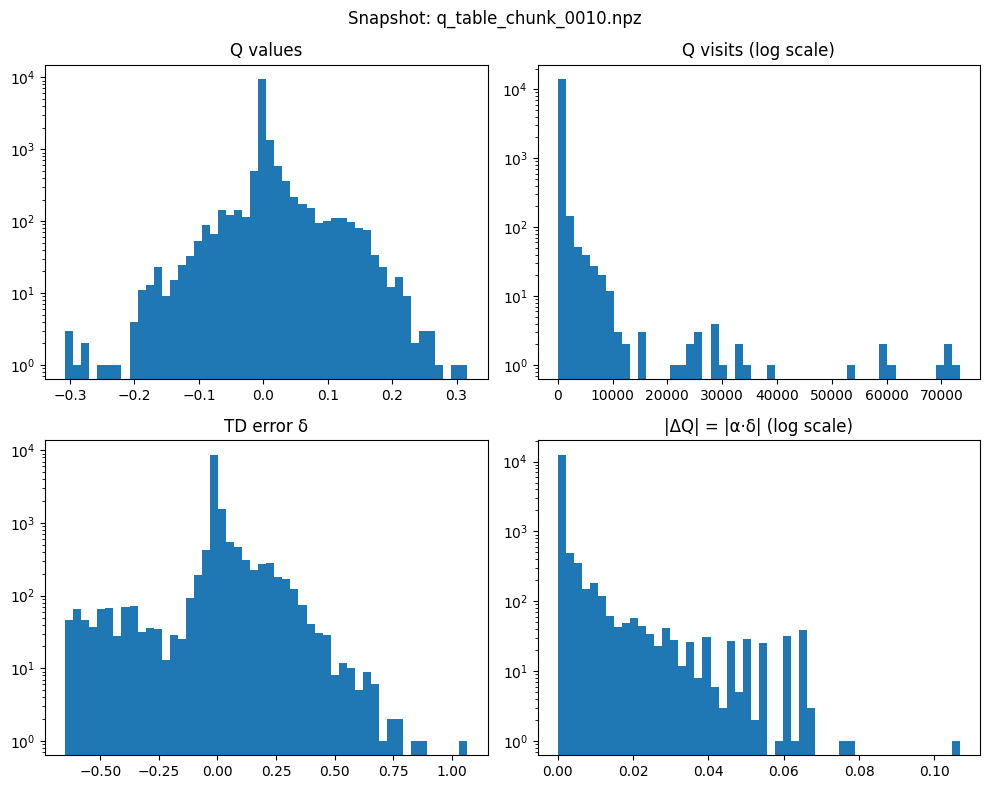

In [65]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_dict_histograms(folder):
    files = sorted([f for f in os.listdir(folder) if f.endswith(".npz")])
    for f in files:
        path = os.path.join(folder, f)
        with np.load(path, allow_pickle=True) as data:
            q            = data["q"].item()
            q_visits     = data["q_visits"].item()
            q_td_error   = data["q_td_error"].item()
            q_update_mag = data["q_update_mag"].item()

        def flatten(d):
            return np.concatenate([np.ravel(v) for v in d.values()]) if d else np.array([])

        q_vals   = flatten(q)
        qv_vals  = flatten(q_visits)
        tde_vals = flatten(q_td_error)
        upm_vals = flatten(q_update_mag)

        fig, axs = plt.subplots(2, 2, figsize=(10,8))
        fig.suptitle(f"Snapshot: {f}")

        axs[0,0].hist(q_vals, bins=50, log=True)
        axs[0,0].set_title("Q values")

        axs[0,1].hist(qv_vals, bins=50, log=True)
        axs[0,1].set_title("Q visits (log scale)")

        axs[1,0].hist(tde_vals, bins=50, log=True)
        axs[1,0].set_title("TD error δ")

        axs[1,1].hist(upm_vals, bins=50, log=True)
        axs[1,1].set_title("|ΔQ| = |α·δ| (log scale)")

        plt.tight_layout()
        plt.show()

# Example usage:
plot_dict_histograms("agent_code/tq_cratehero/dicts")


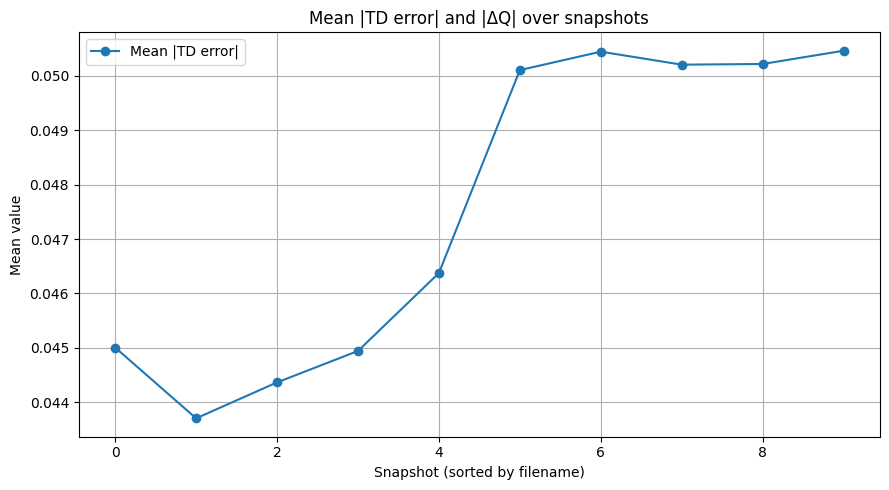

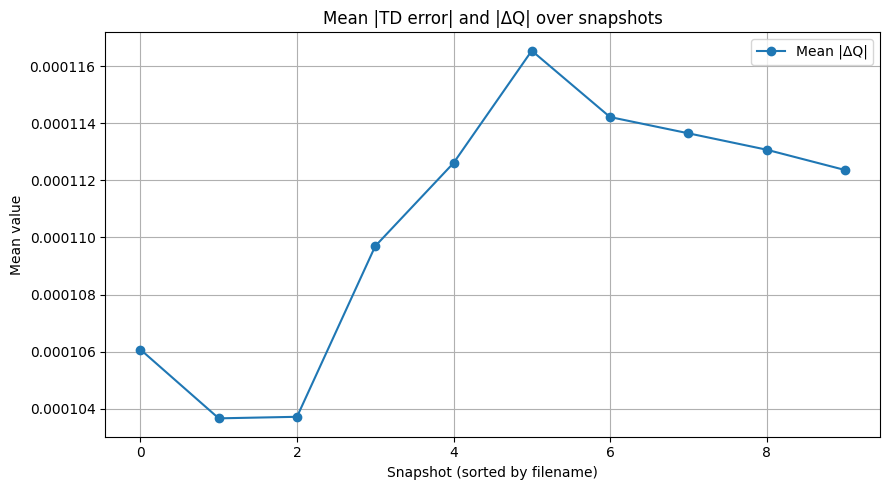

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_td_and_deltaq(folder):
    files = sorted([f for f in os.listdir(folder) if f.endswith(".npz")])

    mean_abs_td   = []
    mean_update   = []
    snapshot_idx  = []

    def flatten(d):
        return np.concatenate([np.ravel(v) for v in d.values()]) if d else np.array([])

    for i, f in enumerate(files):
        path = os.path.join(folder, f)
        with np.load(path, allow_pickle=True) as data:
            td_dict = data["q_td_error"].item()      # dict[state] -> array
            dq_dict = data["q_update_mag"].item()    # dict[state] -> array (magnitudes)

        td_vals = flatten(td_dict)
        dq_vals = flatten(dq_dict)

        mean_abs_td.append(np.abs(td_vals).mean() if td_vals.size else np.nan)
        mean_update.append(dq_vals.mean()          if dq_vals.size else np.nan)
        snapshot_idx.append(i)

    plt.figure(figsize=(9,5))
    plt.plot(snapshot_idx, mean_abs_td,   marker="o", label="Mean |TD error|")
    plt.xlabel("Snapshot (sorted by filename)")
    plt.ylabel("Mean value")
    plt.title("Mean |TD error| and |ΔQ| over snapshots")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9,5))
    plt.plot(snapshot_idx, mean_update,   marker="o", label="Mean |ΔQ|")
    plt.xlabel("Snapshot (sorted by filename)")
    plt.ylabel("Mean value")
    plt.title("Mean |TD error| and |ΔQ| over snapshots")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example:
plot_mean_td_and_deltaq("agent_code/tq_cratehero/dicts")


## Figure 1: Gameplay

`python3 main.py play --agents rule_based_agent rule_based_agent rule_based_agent rule_based_agent --make-video`

In [1]:
from PIL import Image
import os
import re

# Path to folder with your images
folder = 'screenshots/gameplay'

# Regex to match filenames like: "Round 01 (2025-07-24 09-46-17)_00001.png"
pattern = re.compile(r'^Round 01.*_(\d+)\.png$')

# List and sort matching files by frame number
files = sorted(
    [f for f in os.listdir(folder) if pattern.match(f)],
    key=lambda f: int(pattern.match(f).group(1))
)

# Optionally select a subset
selected_files = files


image_paths = [os.path.join(folder, f) for f in selected_files]

# Define crop box: (left, top, right, bottom)
# Example: remove a 10-pixel border on all sides
CROP_BOX = (125, 125, -525, -125)  # negative values mean relative to image size

frames = []
for path in image_paths:
    img = Image.open(path)
    width, height = img.size

    # Compute absolute crop box
    left = CROP_BOX[0]
    top = CROP_BOX[1]
    right = width + CROP_BOX[2]  # e.g., -10 becomes width - 10
    bottom = height + CROP_BOX[3]

    cropped = img.crop((left, top, right, bottom))

    # Create new image with transparent border
    border_size = 8
    bordered = Image.new("RGBA",
                         (cropped.width + 2 * border_size, cropped.height + 2 * border_size),
                         (0, 0, 0, 0))  # fully transparent
    bordered.paste(cropped, (border_size, border_size))

    # Convert to P mode but keep transparency
    frames.append(bordered.convert("P", palette=Image.ADAPTIVE))

# Save to GIF
output_path = 'figures/1_gameplay.gif'
frames[0].save(
    output_path,
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0,
    optimize=True

)

## Figure 2: Explain bombs

In [2]:
from PIL import Image
import os
import re

# Path to folder with your images
folder = 'screenshots/explain_bombs'

# Regex to match filenames like: "Round 01 (2025-07-24 09-46-17)_00001.png"
pattern = re.compile(r'^Round 01.*_(\d+)\.png$')

# List and sort matching files by frame number
files = sorted(
    [f for f in os.listdir(folder) if pattern.match(f)],
    key=lambda f: int(pattern.match(f).group(1))
)
print(files)

# Optionally select a subset
selected_files = files

# Optional: Resize and convert to optimized palette with dithering
target_size = (512, 512)

image_paths = [os.path.join(folder, f) for f in selected_files]

# Define crop box: (left, top, right, bottom)
# Example: remove a 10-pixel border on all sides
CROP_BOX = (125, 125, -525, -40)  # negative values mean relative to image size

frames = []
for path in image_paths:
    img = Image.open(path)
    width, height = img.size

    # Compute absolute crop box
    left = CROP_BOX[0]
    top = CROP_BOX[1]
    right = width + CROP_BOX[2]  # e.g., -10 becomes width - 10
    bottom = height + CROP_BOX[3]

    cropped = img.crop((left, top, right, bottom))

    # Create new image with transparent border
    border_size = 8
    bordered = Image.new("RGBA",
                         (cropped.width + 2 * border_size, cropped.height + 2 * border_size),
                         (0, 0, 0, 0))  # fully transparent
    bordered.paste(cropped, (border_size, border_size))

    # Convert to P mode but keep transparency
    frames.append(bordered.convert("P", palette=Image.ADAPTIVE))

# Save to GIF
output_path = 'figures/2_explain_bombs.gif'
frames[0].save(
    output_path,
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0,
    optimize=True

)

['Round 01 (2025-07-24 09-46-17)_00001.png', 'Round 01 (2025-07-24 09-46-17)_00012.png', 'Round 01 (2025-07-24 09-46-17)_00019.png', 'Round 01 (2025-07-24 09-46-17)_00025.png', 'Round 01 (2025-07-24 09-46-17)_00035.png', 'Round 01 (2025-07-24 09-46-17)_00043.png', 'Round 01 (2025-07-24 09-46-17)_00053.png', 'Round 01 (2025-07-24 09-46-17)_00067.png', 'Round 01 (2025-07-24 09-46-17)_00079.png']


In [4]:
from PIL import Image, ImageDraw, ImageFont
import os
import re

# Folder containing images
folder = 'screenshots/explain_bombs'

# Filename pattern
pattern = re.compile(r'^Round 01.*_(\d+)\.png$')

# Collect and sort files
files = sorted(
    [f for f in os.listdir(folder) if pattern.match(f)],
    key=lambda f: int(pattern.match(f).group(1))
)
print(files)

# Resize/crop parameters
CROP_BOX = (125, 125, -525, -125)  # negative values mean relative to image size

# Stage labels
stage_labels = {
    1: "",
    2: "Frame 0: Move",
    3: "Frame 1: Agent drops the bomb",
    4: "Frame 2: Bomb ticking",
    5: "Frame 3: Bomb ticking",
    6: "Frame 4: Bomb ticking",
    7: "Frame 5: Bomb explodes",
    8: "Frame 6: Explosion remains",
    9: "Frame 7: Agent can place a new bomb",
}

# Load font (fallback if PT Serif not available)
font_size = 16
try:
    font = ImageFont.truetype("fonts/PTSerif-Bold.ttf", font_size)
except IOError:
    ImageFont.load_default()

# Process frames
frames = []
for idx, filename in enumerate(files):
    frame_num = idx + 1
    path = os.path.join(folder, filename)
    img = Image.open(path)
    width, height = img.size

    # Compute crop box
    left = CROP_BOX[0]
    top = CROP_BOX[1]
    right = width + CROP_BOX[2]
    bottom = height + CROP_BOX[3]
    cropped = img.crop((left, top, right, bottom))

    # Create new image with transparent border
    border_size = 8
    bordered = Image.new("RGBA",
                         (cropped.width + 2 * border_size, cropped.height + 2 * border_size),
                         (0, 0, 0, 0))  # fully transparent
    bordered.paste(cropped, (border_size, border_size))

    # Draw annotation
    draw = ImageDraw.Draw(bordered)
    text = stage_labels.get(frame_num, "")
    text_width, text_height = draw.textsize(text, font=font)
    text_position = ((bordered.width - text_width) // 2, 10)
    draw.text(text_position, text, fill="white", font=font, stroke_width=2, stroke_fill="black")

    # Convert to optimized palette for GIF
    palettized = bordered.convert('P', palette=Image.ADAPTIVE, dither=Image.NONE)
    frames.append(palettized)

# Save GIF
output_path = 'figures/2_explain_bombs.gif'
frames[0].save(
    output_path,
    save_all=True,
    append_images=frames[1:],
    duration=1500,
    loop=0,
    optimize=True
)


['Round 01 (2025-07-24 09-46-17)_00001.png', 'Round 01 (2025-07-24 09-46-17)_00012.png', 'Round 01 (2025-07-24 09-46-17)_00019.png', 'Round 01 (2025-07-24 09-46-17)_00025.png', 'Round 01 (2025-07-24 09-46-17)_00035.png', 'Round 01 (2025-07-24 09-46-17)_00043.png', 'Round 01 (2025-07-24 09-46-17)_00053.png', 'Round 01 (2025-07-24 09-46-17)_00067.png', 'Round 01 (2025-07-24 09-46-17)_00079.png']


## Figure 3: State representation

`python3 main.py play --agents user_agent peaceful_agent --turn-based --make-video`

In [93]:
from PIL import Image
import os
import re

# Path to folder with your images
folder = 'screenshots/debug_state'

# Regex to match filenames like: "Round 01 (2025-07-24 09-46-17)_00001.png"
pattern = re.compile(r'^Round 01.*_(\d+)\.png$')

# List and sort matching files by frame number
files = sorted(
    [f for f in os.listdir(folder) if pattern.match(f)],
    key=lambda f: int(pattern.match(f).group(1))
)

# Optionally select a subset
selected_files = files

# Optional: Resize and convert to optimized palette with dithering
target_size = (512, 512)

image_paths = [os.path.join(folder, f) for f in selected_files]

# Define crop box: (left, top, right, bottom)
# Example: remove a 10-pixel border on all sides
CROP_BOX = (125, 125, -75, -40)  # negative values mean relative to image size

frames = []
for path in image_paths:
    img = Image.open(path)
    width, height = img.size

    # Compute absolute crop box
    left = CROP_BOX[0]
    top = CROP_BOX[1]
    right = width + CROP_BOX[2]  # e.g., -10 becomes width - 10
    bottom = height + CROP_BOX[3]

    cropped = img.crop((left, top, right, bottom))

    frames.append(cropped.convert('RGB').convert('P', palette=Image.ADAPTIVE, dither=Image.NONE))

# Save to GIF
output_path = 'figures/3_debug_state.gif'
frames[0].save(
    output_path,
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0,
    optimize=True

)

## Figure 4: Coin Grabber

In [5]:
from PIL import Image
import os
import re

# Path to folder with your images
folder = 'screenshots/coin_grabber'

# Regex to match filenames like: "Round 01 (2025-07-24 09-46-17)_00001.png"
pattern = re.compile(r'^Round 01.*_(\d+)\.png$')

# List and sort matching files by frame number
files = sorted(
    [f for f in os.listdir(folder) if pattern.match(f)],
    key=lambda f: int(pattern.match(f).group(1))
)
print(files)

# Optionally select a subset
selected_files = files


image_paths = [os.path.join(folder, f) for f in selected_files]

# Define crop box: (left, top, right, bottom)
# Example: remove a 10-pixel border on all sides
CROP_BOX = (125, 125, -525, -125)  # negative values mean relative to image size

frames = []
for path in image_paths:
    img = Image.open(path)
    width, height = img.size

    # Compute absolute crop box
    left = CROP_BOX[0]
    top = CROP_BOX[1]
    right = width + CROP_BOX[2]  # e.g., -10 becomes width - 10
    bottom = height + CROP_BOX[3]

    cropped = img.crop((left, top, right, bottom))

    # Create new image with transparent border
    border_size = 8
    bordered = Image.new("RGBA",
                         (cropped.width + 2 * border_size, cropped.height + 2 * border_size),
                         (0, 0, 0, 0))  # fully transparent
    bordered.paste(cropped, (border_size, border_size))

    # Convert to P mode but keep transparency
    frames.append(bordered.convert("P", palette=Image.ADAPTIVE))

# Save to GIF
output_path = 'figures/4_coin_grabber.gif'
frames[0].save(
    output_path,
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0,
    optimize=True

)

['Round 01 (2025-07-24 13-44-56)_00001.png', 'Round 01 (2025-07-24 13-44-56)_00002.png', 'Round 01 (2025-07-24 13-44-56)_00003.png', 'Round 01 (2025-07-24 13-44-56)_00004.png', 'Round 01 (2025-07-24 13-44-56)_00005.png', 'Round 01 (2025-07-24 13-44-56)_00006.png', 'Round 01 (2025-07-24 13-44-56)_00007.png', 'Round 01 (2025-07-24 13-44-56)_00008.png', 'Round 01 (2025-07-24 13-44-56)_00009.png', 'Round 01 (2025-07-24 13-44-56)_00010.png', 'Round 01 (2025-07-24 13-44-56)_00011.png', 'Round 01 (2025-07-24 13-44-56)_00012.png', 'Round 01 (2025-07-24 13-44-56)_00013.png', 'Round 01 (2025-07-24 13-44-56)_00014.png', 'Round 01 (2025-07-24 13-44-56)_00015.png', 'Round 01 (2025-07-24 13-44-56)_00016.png', 'Round 01 (2025-07-24 13-44-56)_00017.png', 'Round 01 (2025-07-24 13-44-56)_00018.png', 'Round 01 (2025-07-24 13-44-56)_00019.png', 'Round 01 (2025-07-24 13-44-56)_00020.png', 'Round 01 (2025-07-24 13-44-56)_00021.png', 'Round 01 (2025-07-24 13-44-56)_00022.png', 'Round 01 (2025-07-24 13-44-56)

## Figure 5: Crate Hero

In [6]:
from PIL import Image
import os
import re

# Path to folder with your images
folder = 'screenshots/crate_hero'

# Regex to match filenames like: "Round 01 (2025-07-24 09-46-17)_00001.png"
pattern = re.compile(r'^Round 01.*_(\d+)\.png$')

# List and sort matching files by frame number
files = sorted(
    [f for f in os.listdir(folder) if pattern.match(f)],
    key=lambda f: int(pattern.match(f).group(1))
)
print(files)

# Optionally select a subset
selected_files = files


image_paths = [os.path.join(folder, f) for f in selected_files]

# Define crop box: (left, top, right, bottom)
# Example: remove a 10-pixel border on all sides
CROP_BOX = (125, 125, -525, -125)  # negative values mean relative to image size

frames = []
for path in image_paths:
    img = Image.open(path)
    width, height = img.size

    # Compute absolute crop box
    left = CROP_BOX[0]
    top = CROP_BOX[1]
    right = width + CROP_BOX[2]  # e.g., -10 becomes width - 10
    bottom = height + CROP_BOX[3]

    cropped = img.crop((left, top, right, bottom))

    # Create new image with transparent border
    border_size = 8
    bordered = Image.new("RGBA",
                         (cropped.width + 2 * border_size, cropped.height + 2 * border_size),
                         (0, 0, 0, 0))  # fully transparent
    bordered.paste(cropped, (border_size, border_size))

    # Convert to P mode but keep transparency
    frames.append(bordered.convert("P", palette=Image.ADAPTIVE))

# Save to GIF
output_path = 'figures/5_crate_hero.gif'
frames[0].save(
    output_path,
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0,
    optimize=True

)

['Round 01 (2025-07-24 15-51-29)_00001.png', 'Round 01 (2025-07-24 15-51-29)_00002.png', 'Round 01 (2025-07-24 15-51-29)_00003.png', 'Round 01 (2025-07-24 15-51-29)_00004.png', 'Round 01 (2025-07-24 15-51-29)_00005.png', 'Round 01 (2025-07-24 15-51-29)_00006.png', 'Round 01 (2025-07-24 15-51-29)_00007.png', 'Round 01 (2025-07-24 15-51-29)_00008.png', 'Round 01 (2025-07-24 15-51-29)_00009.png', 'Round 01 (2025-07-24 15-51-29)_00010.png', 'Round 01 (2025-07-24 15-51-29)_00011.png', 'Round 01 (2025-07-24 15-51-29)_00012.png', 'Round 01 (2025-07-24 15-51-29)_00013.png', 'Round 01 (2025-07-24 15-51-29)_00014.png', 'Round 01 (2025-07-24 15-51-29)_00015.png', 'Round 01 (2025-07-24 15-51-29)_00016.png', 'Round 01 (2025-07-24 15-51-29)_00017.png', 'Round 01 (2025-07-24 15-51-29)_00018.png', 'Round 01 (2025-07-24 15-51-29)_00019.png', 'Round 01 (2025-07-24 15-51-29)_00020.png', 'Round 01 (2025-07-24 15-51-29)_00021.png', 'Round 01 (2025-07-24 15-51-29)_00022.png', 'Round 01 (2025-07-24 15-51-29)

## Figure 6: Allstar

`python3 main.py play --agents tq_allstar peaceful_agent rule_based_agent rule_based_agent --make-video`

In [7]:
from PIL import Image
import os
import re

# Path to folder with your images
folder = 'screenshots/allstar'

# Regex to match filenames like: "Round 01 (2025-07-24 09-46-17)_00001.png"
pattern = re.compile(r'^Round 01.*_(\d+)\.png$')

# List and sort matching files by frame number
files = sorted(
    [f for f in os.listdir(folder) if pattern.match(f)],
    key=lambda f: int(pattern.match(f).group(1))
)

# Optionally select a subset
selected_files = files


image_paths = [os.path.join(folder, f) for f in selected_files]

# Define crop box: (left, top, right, bottom)
# Example: remove a 10-pixel border on all sides
CROP_BOX = (125, 125, -525, -125)  # negative values mean relative to image size

frames = []
for path in image_paths:
    img = Image.open(path)
    width, height = img.size

    # Compute absolute crop box
    left = CROP_BOX[0]
    top = CROP_BOX[1]
    right = width + CROP_BOX[2]  # e.g., -10 becomes width - 10
    bottom = height + CROP_BOX[3]

    cropped = img.crop((left, top, right, bottom))

    # Create new image with transparent border
    border_size = 8
    bordered = Image.new("RGBA",
                         (cropped.width + 2 * border_size, cropped.height + 2 * border_size),
                         (0, 0, 0, 0))  # fully transparent
    bordered.paste(cropped, (border_size, border_size))

    # Convert to P mode but keep transparency
    frames.append(bordered.convert("P", palette=Image.ADAPTIVE))

# Save to GIF
output_path = 'figures/6_allstar.gif'
frames[0].save(
    output_path,
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0,
    optimize=True

)